# Library

In [1]:
import random

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchsummary import summary
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import matplotlib.pyplot as plt

from utils.model import ConvNet
from utils.grad_cam import visualization_per_class
from utils.datasets import CustomDataset

# Config

In [2]:
CFG = {'seed': 42,
       'bs': 16,
       'imgsz': (64, 64),  # height, width
       'mean': (0.485, 0.456, 0.406),
       'std': (0.229, 0.224, 0.225),
       'n_cls': 3,
       'lr': 1e-3,
       'num_epochs': 3}

# Fix Seed

In [3]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed_everything(CFG['seed'])

# Data

In [4]:
basic_transform = transforms.Compose([transforms.Resize((64, 64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=CFG['mean'], std=CFG['std'])])

augmented_transform = transforms.Compose([transforms.Resize((64, 64)),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomRotation(15),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=CFG['mean'], std=CFG['std'])])

In [5]:
dataset = ImageFolder('./data/train/')

samples = np.array(dataset.samples)
labels = np.array(dataset.targets)
indices = np.arange(len(dataset))

# train, test 분리(stratify)
train_idx, valid_idx = train_test_split(indices,
                                        test_size=0.3,
                                        stratify=labels,
                                        random_state=CFG['seed'])

# train, valid 분리(stratify)
valid_idx, test_idx = train_test_split(valid_idx,
                                       test_size=0.5,
                                       stratify=labels[valid_idx],
                                       random_state=CFG['seed'])

# train : 70% 
# valid : 15%
# test  : 15%
minority_class = dataset.class_to_idx['tomato']

train_dataset = CustomDataset(samples, train_idx, minority_class, basic_transform, augmented_transform)
valid_dataset = CustomDataset(samples, valid_idx, minority_class, basic_transform, augmented_transform, is_train=False)
test_dataset = CustomDataset(samples, test_idx, minority_class, basic_transform, augmented_transform, is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=CFG['bs'], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# model, loss, optimizer 정의

In [6]:
# model, loss, optimizer
model = ConvNet()
model.load_state_dict(torch.load("./checkpoints/conv_net.pth", map_location="cpu", weights_only=True))
model.fc = nn.Linear(model.fc.in_features, CFG['n_cls'])  # 클래스 수 변경

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG['lr'])

# 전이 학습 전 Gram-CAM 시각화
- 셀을 실행할 때마다 각 클래스 별 무작위 이미지 확인 가능

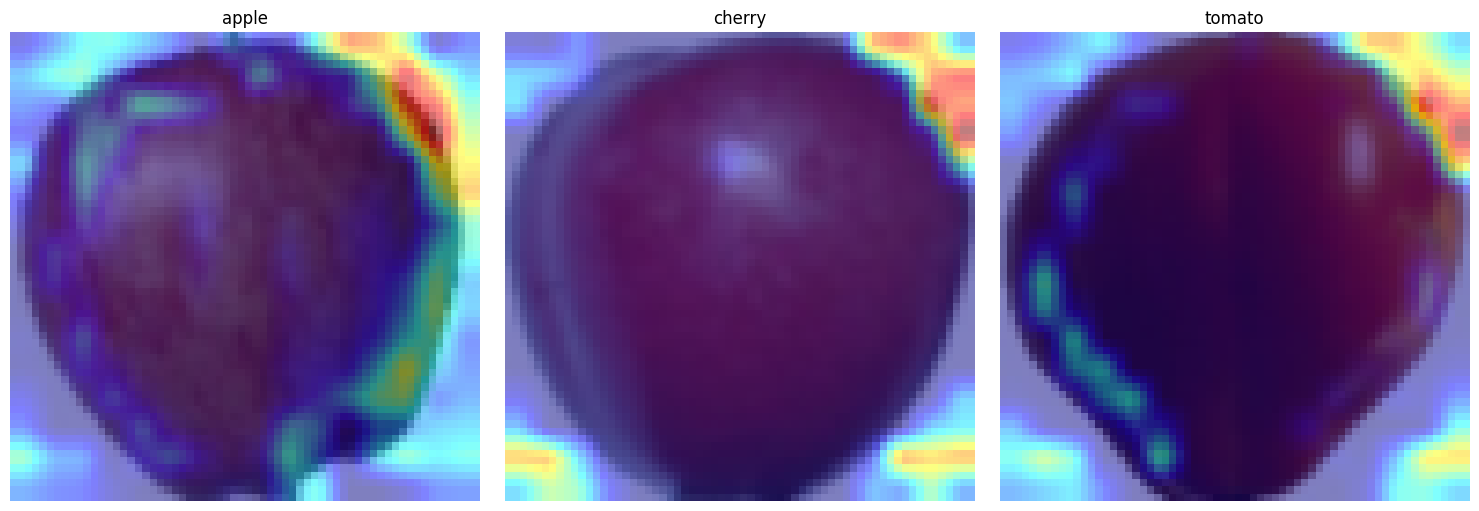

In [7]:
visualization_per_class(model, 
                        dataset, 
                        target_layer=model.conv3,
                        transform=basic_transform,
                        mean=CFG['mean'], 
                        std=CFG['std'])

# Train

In [8]:
best_model_weights = None
max_f1_score = 0.0

# 학습 루프
for epoch in range(CFG['num_epochs']):
    model.train()
    
    total_loss = 0
    
    ########## Train ##########
    for inputs, labels in train_dataloader:        
        optimizer.zero_grad()
        
        outputs, _ = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{CFG['num_epochs']}]")
    print(f"Train Loss: {total_loss / len(train_dataloader):.4f}")
    
    ########## Validation ##########
    model.eval()
    
    epoch_preds = []
    epoch_labels = []
    
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            epoch_preds.extend(preds.detach().cpu().numpy())
            epoch_labels.extend(labels.detach().cpu().numpy())
            
    val_f1_score = f1_score(epoch_labels, epoch_preds, average='macro')        
    print(f"Valid F1-Score: {val_f1_score:.4f}\n")

    # best score, weights 업데이트
    if max_f1_score < val_f1_score:
        best_model_weights = model.state_dict()
        max_f1_score = val_f1_score
        
# 모델 파일 저장
torch.save(model.state_dict(), './checkpoints/fine_tuned_conv_net.pth')

Epoch [1/3]
Train Loss: 0.1676
Valid F1-Score: 1.0000

Epoch [2/3]
Train Loss: 0.0030
Valid F1-Score: 1.0000

Epoch [3/3]
Train Loss: 0.0006
Valid F1-Score: 1.0000



# Test Dataset 샘플 이미지 시각화
- 셀을 실행할 때마다 test dataset에서 무작위로 9개의 샘플을 추출 하여 모델의 예측 결과를 시각화.

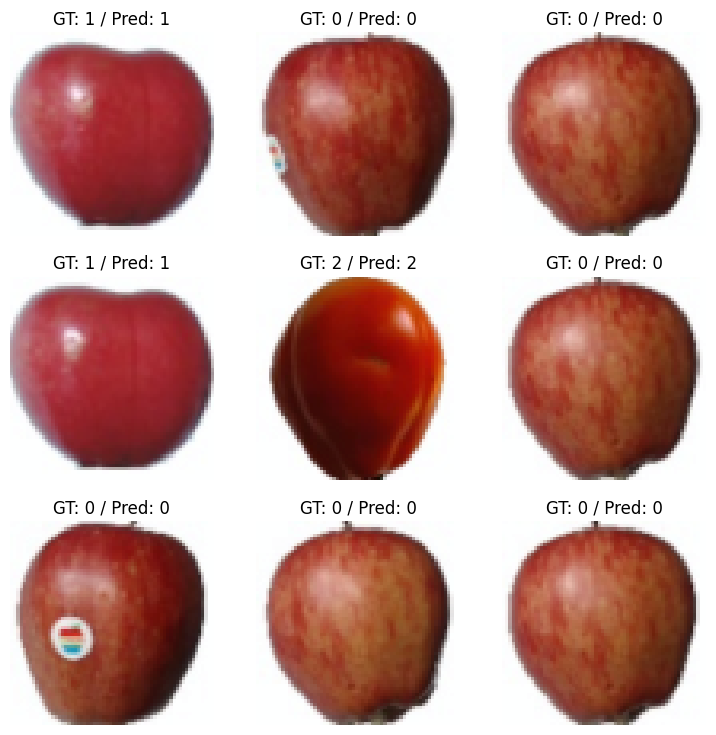

In [9]:
# test dataset 전체에서 무작위로 9개 샘플 추출
n_samples = 9
indices = random.sample(range(len(test_dataset)), n_samples)

# 이미지 시각화
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

model.eval()
with torch.no_grad():
    for i, idx in enumerate(indices):
        img, label = test_dataset[idx]
        input_tensor = img.unsqueeze(0)
        output, _ = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()
        
        # 이미지 역정규화
        img_display = img.permute(1, 2, 0).numpy()
        img_display = (img_display * CFG['std']) + CFG['mean']
        img_display = np.clip(img_display, 0, 1)

        ax = axes.flat[i]
        ax.imshow(img_display)
        ax.set_title(f"GT: {label} / Pred: {predicted_label}")
        ax.axis('off')

plt.show()

# 모델 성능 평가
- 데이터 셋
    - train : 212 장
    - valid : 46 장
    - test  : 46 장

In [10]:
# Test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs, _ = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        
    test_f1_score = f1_score(all_labels, all_preds, average='macro')

print(f"Test F1-Score: {test_f1_score}")

Test F1-Score: 1.0


# 학습 완료 후 Grad-CAM 시각화
- 셀을 실행할 때마다 각 클래스 별 무작위 이미지 확인 가능

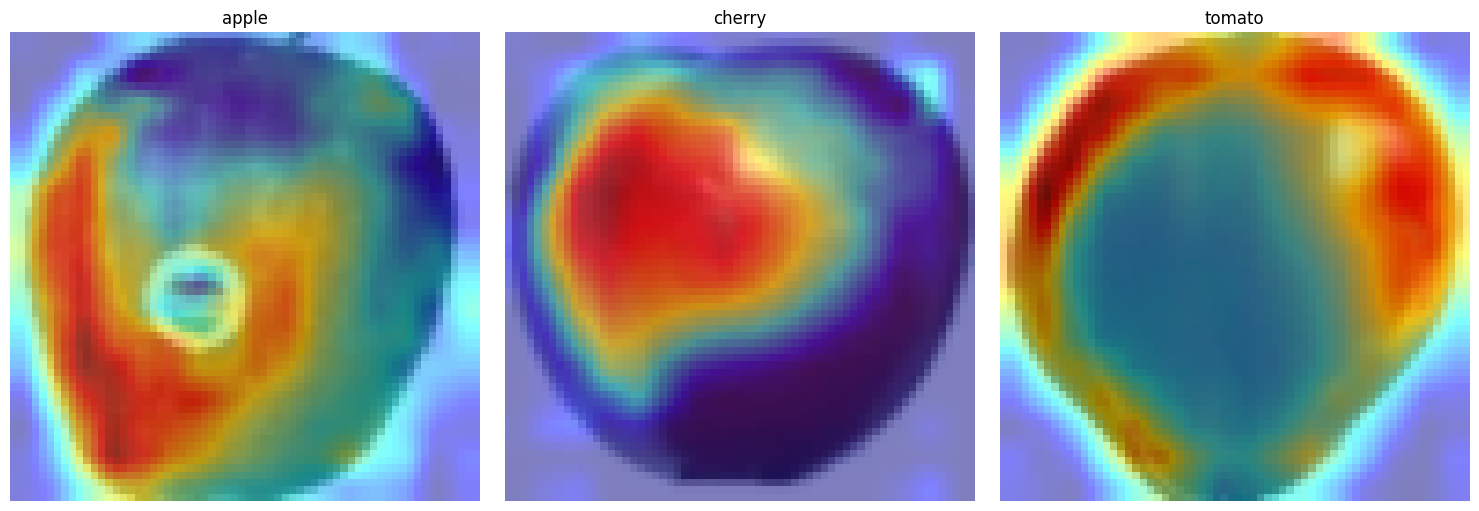

In [11]:
visualization_per_class(model, 
                        dataset, 
                        target_layer=model.conv3,
                        transform=basic_transform,
                        mean=CFG['mean'], 
                        std=CFG['std'])